### Carregamento das Bibliotecas e Dados

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import os
import sys

# Adicionar pasta utils ao path
sys.path.append('./utils')
from generos_onehot import carregar_ou_processar_generos, obter_colunas_generos_limpos

# Configurar paths
INPUT_DATA_PATH = './datas/'
OUTPUT_PATH = './outputs/'
os.makedirs(OUTPUT_PATH, exist_ok=True)

In [2]:
# Carregar dados de gêneros processados (gêneros adultos já filtrados automaticamente)
df_generos = carregar_ou_processar_generos()
colunas_generos = obter_colunas_generos_limpos(df_generos)
X = df_generos[colunas_generos].values

print(f"Matriz para clustering: {X.shape}")
print(f"Gêneros incluídos: {colunas_generos}")

Carregando arquivo processado: ./datas/generos_onehot.csv
Dados carregados: (20237, 19)
Nenhum gênero adulto encontrado para remover.
Nenhum gênero adulto encontrado para remover.
Matriz para clustering: (20237, 16)
Gêneros incluídos: ['Action', 'Adventure', 'Avant Garde', 'Award Winning', 'Comedy', 'Drama', 'Fantasy', 'Gourmet', 'Horror', 'Mystery', 'Romance', 'Sci-Fi', 'Slice of Life', 'Sports', 'Supernatural', 'Suspense']


### Determinação do Número Ideal de Clusters (Método do Cotovelo vs Silhouette)

In [3]:
# Testar diferentes números de clusters (K)
k_range = range(2, 15)
inertias = []
silhouette_scores = []

for k in k_range:
    # Treinar K-Means
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X)
    
    # Calcular métricas
    inertia = kmeans.inertia_
    silhouette = silhouette_score(X, cluster_labels)
    inertias.append(inertia)
    silhouette_scores.append(silhouette)
    
    print(f"K={k}: Inércia={inertia:.0f}, Silhouette Score={silhouette:.3f}")

print("Análise concluída!")

K=2: Inércia=24118, Silhouette Score=0.198
K=3: Inércia=20634, Silhouette Score=0.228
K=4: Inércia=18786, Silhouette Score=0.246
K=5: Inércia=17355, Silhouette Score=0.260
K=6: Inércia=16221, Silhouette Score=0.273
K=7: Inércia=15266, Silhouette Score=0.285
K=8: Inércia=14429, Silhouette Score=0.302
K=9: Inércia=13878, Silhouette Score=0.313
K=10: Inércia=13477, Silhouette Score=0.318
K=11: Inércia=12182, Silhouette Score=0.363
K=12: Inércia=11879, Silhouette Score=0.362
K=13: Inércia=11364, Silhouette Score=0.370
K=14: Inércia=10902, Silhouette Score=0.395
Análise concluída!


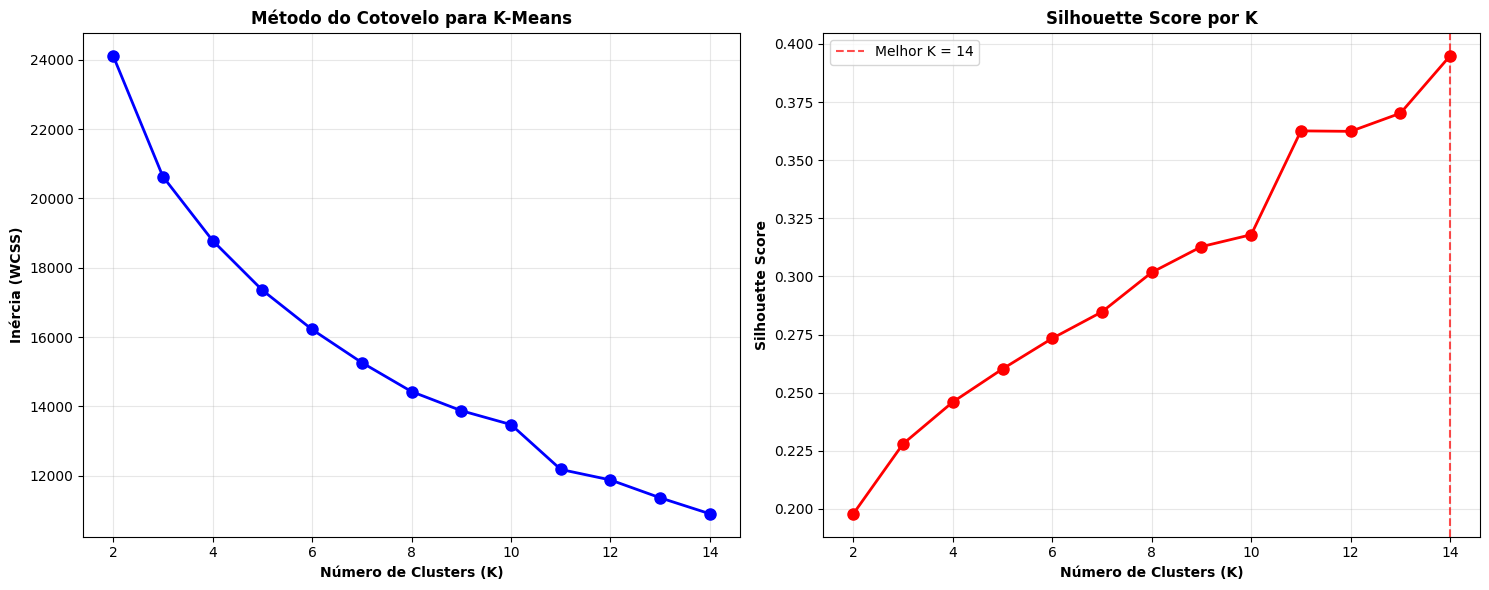

K com melhor silhouette score: 14


In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Método do Cotovelo
ax1.plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Número de Clusters (K)', fontweight='bold')
ax1.set_ylabel('Inércia (WCSS)', fontweight='bold')
ax1.set_title('Método do Cotovelo para K-Means', fontweight='bold')
ax1.grid(True, alpha=0.3)

# Silhouette Score
ax2.plot(k_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
ax2.set_xlabel('Número de Clusters (K)', fontweight='bold')
ax2.set_ylabel('Silhouette Score', fontweight='bold')
ax2.set_title('Silhouette Score por K', fontweight='bold')
ax2.grid(True, alpha=0.3)

# Marcar melhor silhouette
best_silhouette_k = k_range[np.argmax(silhouette_scores)]
ax2.axvline(x=best_silhouette_k, color='red', linestyle='--', alpha=0.7,
            label=f'Melhor K = {best_silhouette_k}')
ax2.legend()

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_PATH, 'nb2_elbow_silhouette.png'), 
            dpi=300, bbox_inches='tight')
plt.show()

# print(f"K sugerido pelo método do cotovelo: {cotovelo_k}")
print(f"K com melhor silhouette score: {best_silhouette_k}")

### Treinamento do Modelo K-Means com K Ideal

In [37]:
# Usa K=3 baseado na análise do Cotovelo
k_final = 3

# Treinar modelo final
kmeans_final = KMeans(n_clusters=k_final, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(X)

# Adicionar labels ao dataframe
df_generos['cluster'] = cluster_labels
print(f"Silhouette Score final: {silhouette_score(X, cluster_labels):.3f}")

# Verificar distribuição dos clusters
cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()
print("\nDistribuição dos animes por cluster:")
print(cluster_counts)

Silhouette Score final: 0.228

Distribuição dos animes por cluster:
0    5029
1    9114
2    6094
Name: count, dtype: int64


### Redução Dimensional para Visualização

In [38]:
# Aplicar PCA para reduzir para 2D para visualização
print("Aplicando PCA para visualização...")
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

print(f"Variância explicada pelo PC1: {pca.explained_variance_ratio_[0]:.3f}")
print(f"Variância explicada pelo PC2: {pca.explained_variance_ratio_[1]:.3f}")
print(f"Variância total explicada: {sum(pca.explained_variance_ratio_):.3f}")

Aplicando PCA para visualização...
Variância explicada pelo PC1: 0.202
Variância explicada pelo PC2: 0.155
Variância total explicada: 0.357


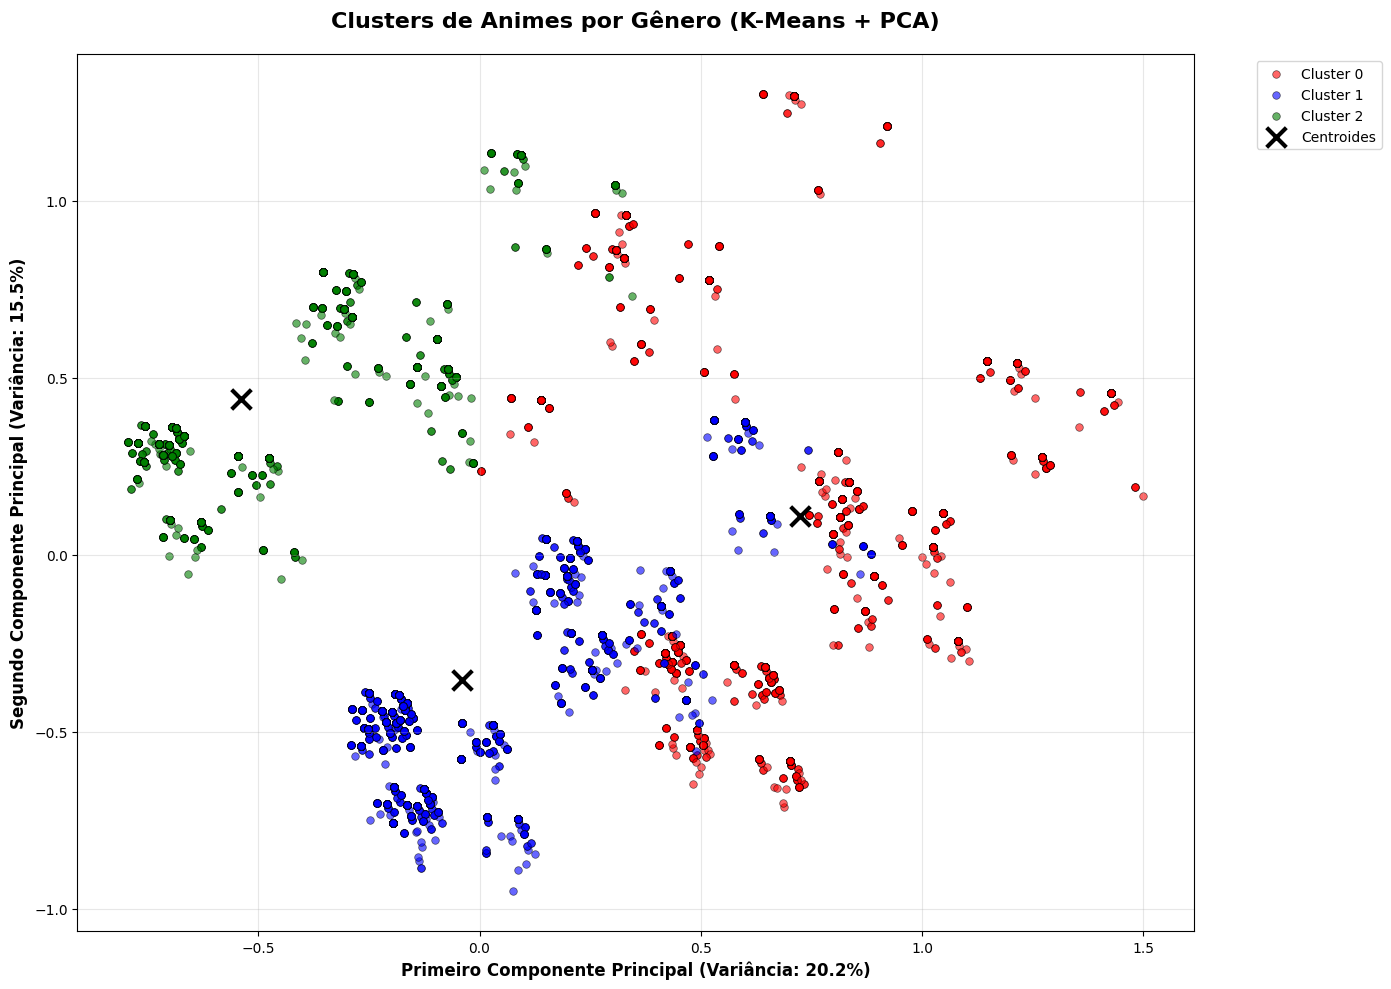

In [39]:
# Visualizar clusters em 2D
plt.figure(figsize=(14, 10))

# Cores para os clusters
colors = [
    'red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray',
    'olive', 'cyan', 'magenta', 'gold', 'teal', 'navy', 'lime'
]

cluster_names = [f'Cluster {i}' for i in range(k_final)]

# Plotar cada cluster
for i in range(k_final):
    cluster_mask = cluster_labels == i
    plt.scatter(X_pca[cluster_mask, 0], X_pca[cluster_mask, 1],
                c=colors[i], label=cluster_names[i], 
                alpha=0.6, s=30, edgecolors='black', linewidth=0.5)

# Plotar centroides no espaço PCA
centroides_pca = pca.transform(kmeans_final.cluster_centers_)
plt.scatter(centroides_pca[:, 0], centroides_pca[:, 1], 
            c='black', marker='x', s=200, linewidth=3, label='Centroides')

# Configurar gráfico
plt.xlabel(f'Primeiro Componente Principal (Variância: {pca.explained_variance_ratio_[0]:.1%})', 
            fontsize=12, fontweight='bold')
plt.ylabel(f'Segundo Componente Principal (Variância: {pca.explained_variance_ratio_[1]:.1%})', 
            fontsize=12, fontweight='bold')
plt.title('Clusters de Animes por Gênero (K-Means + PCA)', 
            fontsize=16, fontweight='bold', pad=20)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.savefig(os.path.join(OUTPUT_PATH, 'nb2_clusters_pca.png'), 
            dpi=300, bbox_inches='tight')
plt.show()

### Análise dos Clusters: Características de cada Grupo

In [40]:
for cluster_id in range(k_final):
    cluster_mask = df_generos['cluster'] == cluster_id
    cluster_data = df_generos[cluster_mask]
    
    print(f"\nCLUSTER {cluster_id} ({len(cluster_data)} animes)")
    print("-" * 30)
    
    # Gêneros mais comuns neste cluster
    generos_medios = cluster_data[colunas_generos].mean().sort_values(ascending=False)
    top_generos = generos_medios.head(5)
    
    for genero, score in top_generos.items():
        print(f"{genero}: {score:.3f}", end=" | ")
    
    print("")


CLUSTER 0 (5029 animes)
------------------------------
Action: 0.993 | Fantasy: 0.395 | Adventure: 0.372 | Sci-Fi: 0.349 | Comedy: 0.161 | 

CLUSTER 1 (9114 animes)
------------------------------
Fantasy: 0.199 | Drama: 0.196 | Adventure: 0.129 | Slice of Life: 0.123 | Sci-Fi: 0.107 | 

CLUSTER 2 (6094 animes)
------------------------------
Comedy: 1.000 | Fantasy: 0.150 | Romance: 0.149 | Adventure: 0.109 | Sci-Fi: 0.087 | 


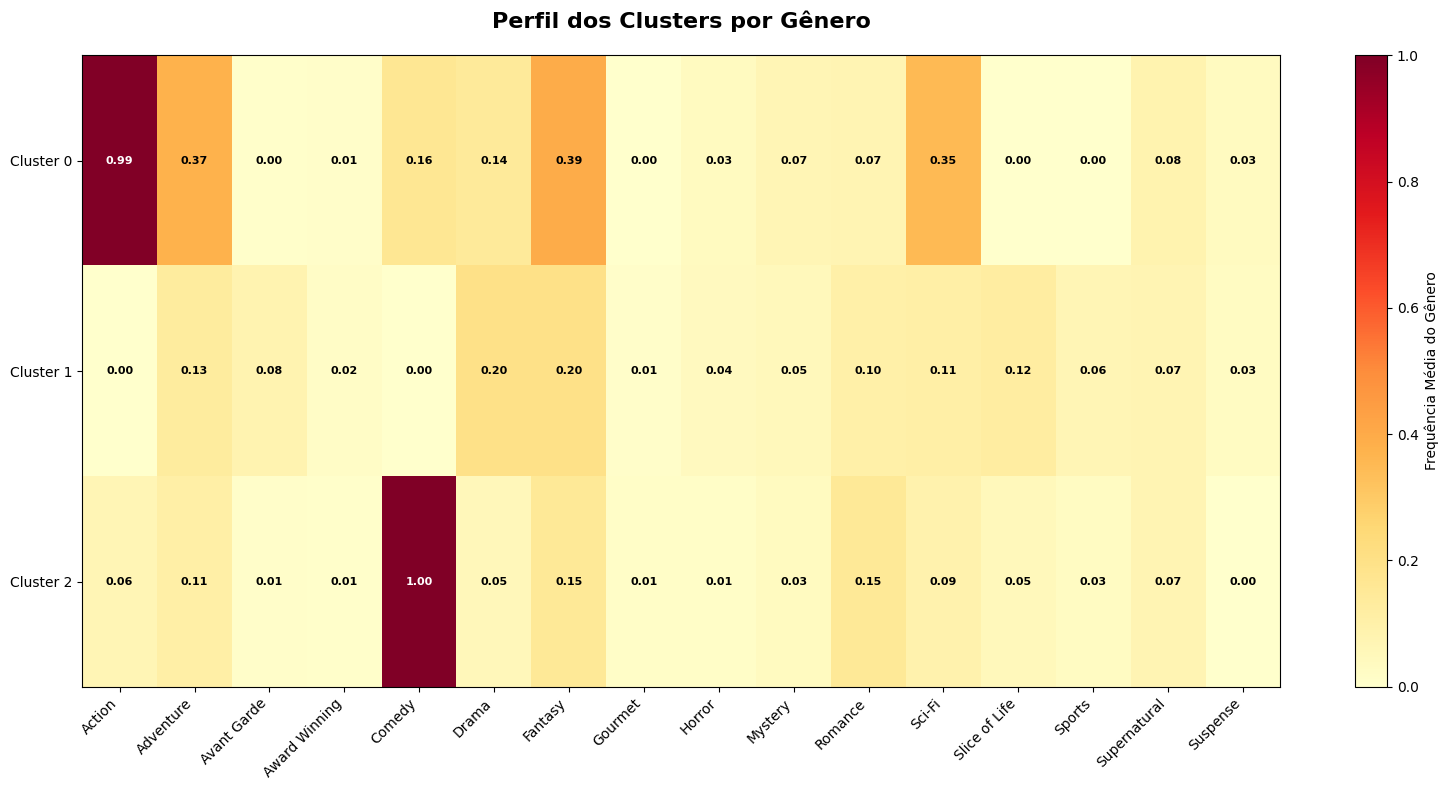

In [41]:
# Criar heatmap das características dos clusters
cluster_profiles = []
for cluster_id in range(k_final):
    cluster_mask = df_generos['cluster'] == cluster_id
    cluster_mean = df_generos[cluster_mask][colunas_generos].mean()
    cluster_profiles.append(cluster_mean)

cluster_profiles_df = pd.DataFrame(cluster_profiles, 
                                    index=[f'Cluster {i}' for i in range(k_final)],
                                    columns=colunas_generos)

# Plotar heatmap
plt.figure(figsize=(16, 8))
im = plt.imshow(cluster_profiles_df.values, cmap='YlOrRd', aspect='auto')
plt.xticks(range(len(colunas_generos)), colunas_generos, rotation=45, ha='right')
plt.yticks(range(k_final), [f'Cluster {i}' for i in range(k_final)])
for i in range(k_final):
    for j in range(len(colunas_generos)):
        value = cluster_profiles_df.iloc[i, j]
        color = 'white' if value > 0.5 else 'black'
        plt.text(j, i, f'{value:.2f}', ha='center', va='center', 
                color=color, fontweight='bold', fontsize=8)

# Adicionar colorbar e título
plt.colorbar(im, label='Frequência Média do Gênero')
plt.title('Perfil dos Clusters por Gênero', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()

plt.savefig(os.path.join(OUTPUT_PATH, 'nb2_cluster_heatmap.png'), 
            dpi=300, bbox_inches='tight')
plt.show()

### Uso prático: categorização de tipos "genéricos" de animes

In [42]:
cluster_interpretations = {}

for cluster_id in range(k_final):
    cluster_mask = df_generos['cluster'] == cluster_id
    cluster_data = df_generos[cluster_mask]
    
    # Gêneros mais característicos
    generos_medios = cluster_data[colunas_generos].mean().sort_values(ascending=False)
    top_3_generos = generos_medios.head(3)
    
    # Criar nome interpretativo
    main_genres = list(top_3_generos.index)
    if 'Action' in main_genres and 'Adventure' in main_genres:
        nome = "Animes de Ação e Aventura"
    elif 'Comedy' in main_genres and 'Slice of Life' in main_genres:
        nome = "Animes de Comédia e Cotidiano"
    elif 'Romance' in main_genres:
        nome = "Animes Românticos"
    elif 'Horror' in main_genres or 'Supernatural' in main_genres:
        nome = "Animes Sobrenaturais/Terror"
    elif 'Sci-Fi' in main_genres:
        nome = "Animes de Ficção Científica"
    elif 'Drama' in main_genres:
        nome = "Animes Dramáticos"
    else:
        # Usar os 2 gêneros principais
        nome = f"Animes de {main_genres[0]} e {main_genres[1]}"
    
    cluster_interpretations[cluster_id] = {
        'nome': nome,
        'generos_principais': main_genres[:3],
        'quantidade': len(cluster_data)
    }

for cluster_id, info in cluster_interpretations.items():
    print(f"\n{cluster_id + 1}. {info['nome']}")
    print(f"   - Quantidade: {info['quantidade']} animes")
    print(f"   - Gêneros principais: {', '.join(info['generos_principais'])}")


1. Animes de Ação e Aventura
   - Quantidade: 5029 animes
   - Gêneros principais: Action, Fantasy, Adventure

2. Animes Dramáticos
   - Quantidade: 9114 animes
   - Gêneros principais: Fantasy, Drama, Adventure

3. Animes Românticos
   - Quantidade: 6094 animes
   - Gêneros principais: Comedy, Fantasy, Romance


#### Explicação dos Resultados

O algoritmo K-Means conseguiu identificar grupos temáticos naturais no universo dos animes, revelando padrões interessantes nas combinações de gêneros.

**Principais Descobertas:**

1. **Formação de Grupos**: O K-Means encontrou clusters com características distintas, cada um representando um "tipo" ou "família" de animes com combinações similares de gêneros.
   -  Os clusters bem separados indicam que existem realmente grupos distintos de animes.

2. **Método do Cotovelo**: A análise da inércia nos ajudou a determinar que 6 clusters oferecem um bom equilíbrio entre simplicidade e capacidade de capturar a diversidade dos dados.

3. **Interpretabilidade**: Cada cluster pode ser interpretado como um "subgênero" ou "categoria temática" específica:
   - Alguns clusters focam em ação e aventura
   - Outros em comédia e slice of life
   - Há grupos especializados em romance, ficção científica, etc.

**Resposta à Pergunta: _"Os animes seguem alguuns estilos (agrupamentos de gêneros)?"_**: 
Sim, existem alguns grupos temáticos naturais bem definidos! O K-Means revelou que os animes não estão distribuídos aleatoriamente no espaço de gêneros, mas formam agrupamentos coerentes que refletem diferentes "fórmulas" ou "estilos" de anime.

**Aplicações Práticas**: 
- **Sistemas de Recomendação**: Usuários que gostam de animes de um cluster provavelmente gostarão de outros do mesmo grupo
- **Análise de Mercado**: Produtores podem identificar nichos menos explorados
- **Classificação**: Novos animes podem ser automaticamente categorizados

---

### Analise em 3D

In [43]:
print("Aplicando PCA para visualização...")
pca = PCA(n_components=3, random_state=42)
X_pca = pca.fit_transform(X)

print(f"Variância explicada pelo PC1: {pca.explained_variance_ratio_[0]:.3f}")
print(f"Variância explicada pelo PC2: {pca.explained_variance_ratio_[1]:.3f}")
print(f"Variância explicada pelo PC3: {pca.explained_variance_ratio_[2]:.3f}")
print(f"Variância total explicada: {sum(pca.explained_variance_ratio_):.3f}")

Aplicando PCA para visualização...
Variância explicada pelo PC1: 0.202
Variância explicada pelo PC2: 0.155
Variância explicada pelo PC3: 0.126
Variância total explicada: 0.483


In [44]:
# Alternativa 1: Usar plotly para gráficos 3D interativos
import plotly.graph_objects as go
import plotly.express as px

# Cores para os clusters
colors = [
    'red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray',
    'olive', 'cyan', 'magenta', 'gold', 'teal', 'navy', 'lime'
]

cluster_names = [f'Cluster {i}' for i in range(k_final)]

# Criar DataFrame para plotly
df_plot = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1], 
    'PC3': X_pca[:, 2],
    'Cluster': cluster_labels,
    'Cluster_Name': [f'Cluster {i}' for i in cluster_labels]
})

# Criar gráfico 3D interativo
fig = px.scatter_3d(df_plot, 
                    width=1280,
                    height=720,
                    x='PC1', y='PC2', z='PC3',
                    color='Cluster_Name',
                    title='Clusters de Animes - Visualização 3D Interativa',
                    labels={
                        'PC1': f'PC1 (Variância: {pca.explained_variance_ratio_[0]:.1%})',
                        'PC2': f'PC2 (Variância: {pca.explained_variance_ratio_[1]:.1%})',
                        'PC3': f'PC3 (Variância: {pca.explained_variance_ratio_[2]:.1%})'
                    })

# Recalcular centroides no espaço PCA atual (garante que temos 3 coordenadas)
# kmeans_final.cluster_centers_ está no espaço original de features; pca.transform projeta para os componentes atuais
centroides_pca = pca.transform(kmeans_final.cluster_centers_)

# Adicionar centroides
for i, centroide in enumerate(centroides_pca):
    # proteger caso a PCA tenha menos de 3 componentes (uso robusto)
    x_val = centroide[0] if centroide.shape[0] > 0 else 0
    y_val = centroide[1] if centroide.shape[0] > 1 else 0
    z_val = centroide[2] if centroide.shape[0] > 2 else 0

    fig.add_trace(go.Scatter3d(
        x=[x_val], y=[y_val], z=[z_val],
        mode='markers',
        marker=dict(size=15, color='black', symbol='x'),
        name=f'Centroide {i}',
        showlegend=False
    ))

fig.show()